In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Relationship
true_intercept = 5
true_slope = 2

# Predictor
n_obs = 100
x_mean = 5
x_sd = 3
x = rng.normal(x_mean, x_sd, n_obs)
xarray = xr.DataArray(x, dims = "outcome_dim_0") # For plotting with arviz
xarray = xarray.assign_coords({"outcome_dim_0": np.arange(0, 100, 1)})

# Target
true_line = true_intercept + true_slope * x
noise_mean = 0
noise_sd = 5
noise = rng.normal(noise_mean, noise_sd, n_obs)
y = true_line + noise

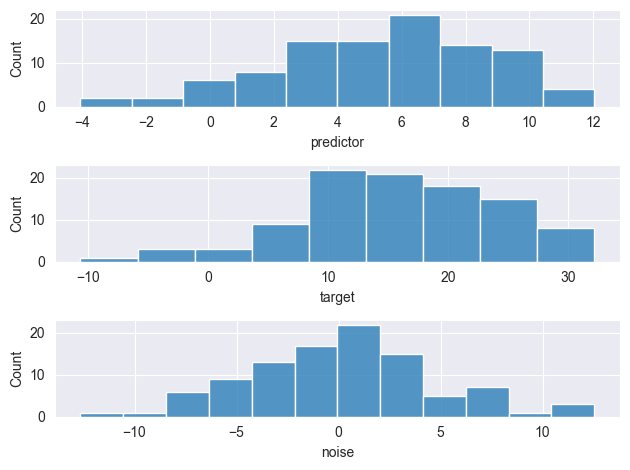

In [5]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(y, ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

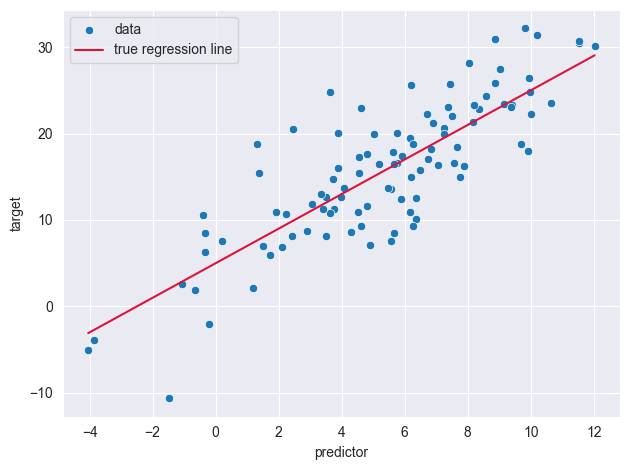

In [6]:
# True regression line
_ = sns.scatterplot(x = x, y = y, label = "data")
_ = sns.lineplot(x = x, y = true_line, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Frequentist OLS

In [7]:
constant = np.ones(n_obs)
exog = np.stack([x, constant]).transpose()

In [8]:
ols = OLS(endog = y, exog = exog)

In [9]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [10]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     222.3
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           6.01e-27
Time:                        17:22:12   Log-Likelihood:                -293.67
No. Observations:                 100   AIC:                             591.3
Df Residuals:                      98   BIC:                             596.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0569      0.138     14.911      0.000       1.783       2.331
const          4.8731      0.870      5.603      0.000       3.147       6.599
==============================================================================
Omnibus:                        1.386   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.874
Skew:                           0.176   Prob(JB):                        0.646
Kurtosis:                       3.293   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

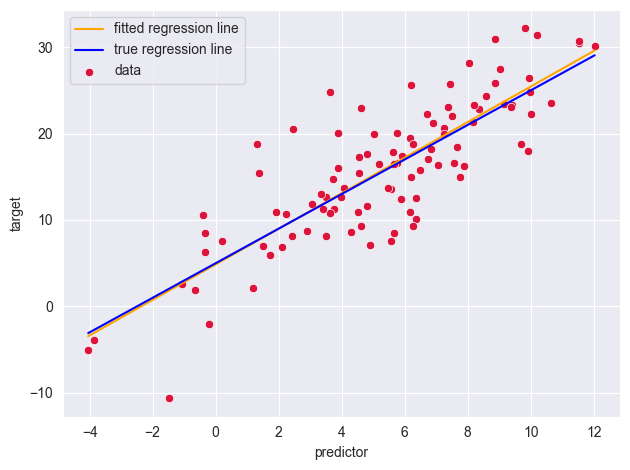

In [11]:
_ = sns.lineplot(
    x = x, 
    y = ols_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = sns.scatterplot(x = x, y = y, color = "crimson", label = "data")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Flat prior


In [12]:
# Create model
flat_model = pm.Model()

In [13]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 10)
    slope = pm.Normal("slope", mu = 0, sigma = 10)
    error = pm.HalfNormal("error", sigma = 10)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [14]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


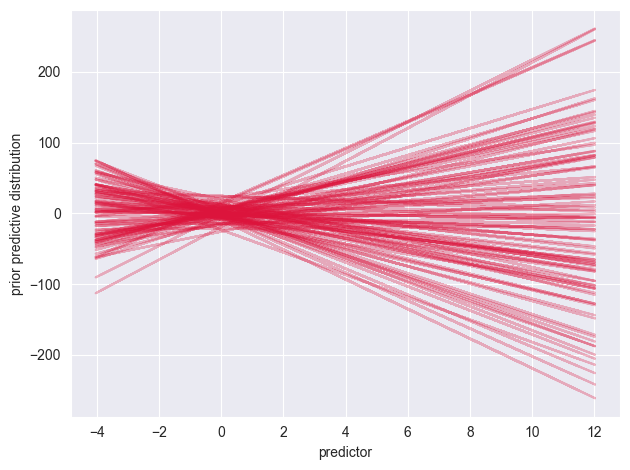

In [15]:
# Prior predictive check
y_flat_prior = (flat_prior.prior["intercept"] + flat_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [16]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [17]:
# Print posterior distribution summaries
az.summary(flat_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.8186,0.8732,3.2499,6.5150,0.0190,0.0134,2108.5443,1935.5024,1.0023
slope,2.0652,0.1373,1.8143,2.3241,0.0030,0.0021,2122.3799,2293.8366,1.0014
error,4.6521,0.3408,4.0612,5.3151,0.0071,0.0050,2292.0995,2461.7515,1.0005


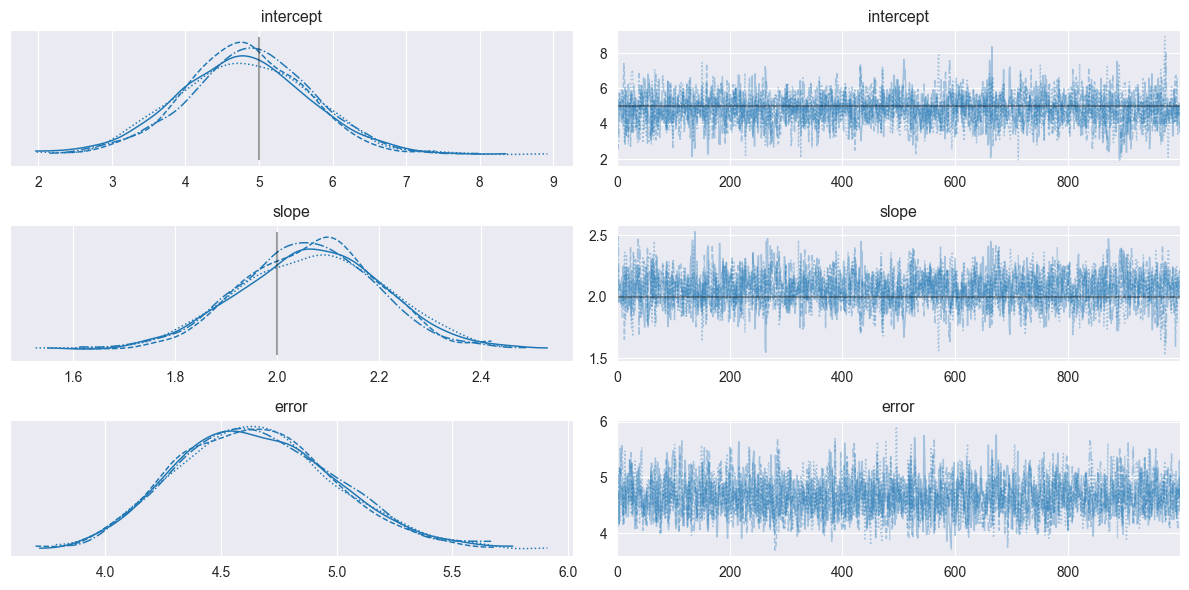

In [18]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

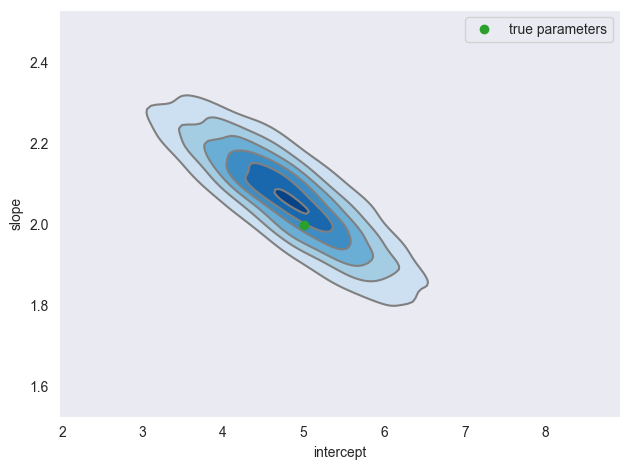

In [19]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(flat_posterior, var_names="intercept"),
    az.extract(flat_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

In [20]:
# Simulate fitted regression lines
flat_fitted = (flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray)

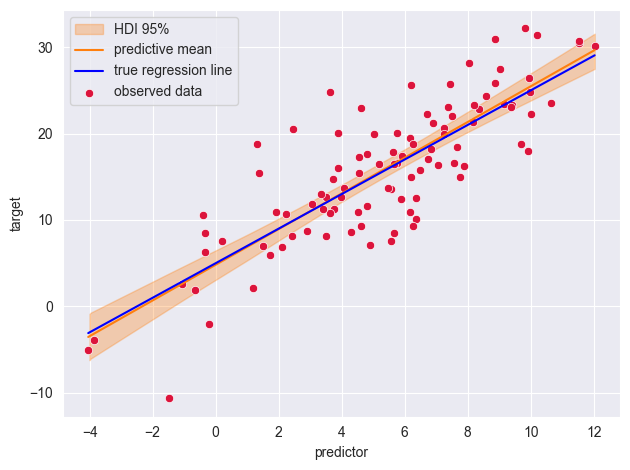

In [21]:
# Plot fitted vs. actual relationship

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    flat_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(flat_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "C1")

# True regression line
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")

# True observations
_ = sns.scatterplot(x = x, y = y, label = "observed data", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [22]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


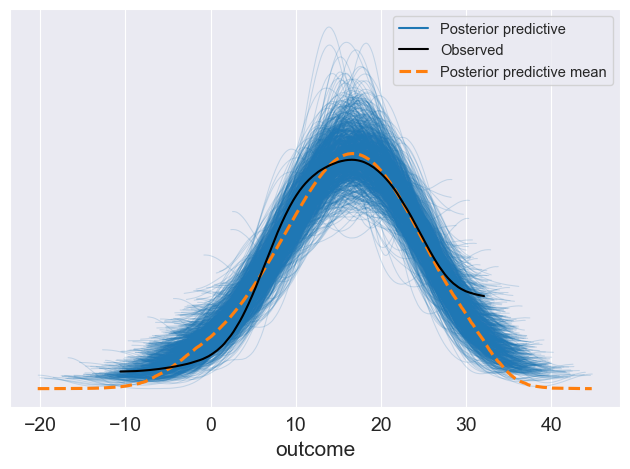

In [23]:
_ = az.plot_ppc(flat_posterior, num_pp_samples = 1000)

## Strong informative prior

In [24]:
# Create model
strong_model = pm.Model()

In [25]:
# Define priors & likelihood
with strong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 4.5, sigma = 1)
    slope = pm.Normal("slope", mu = 1.5, sigma = 0.5)
    error = pm.HalfNormal("error", sigma = 5.5)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [26]:
# Sample from the prior
with strong_model:
    strong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


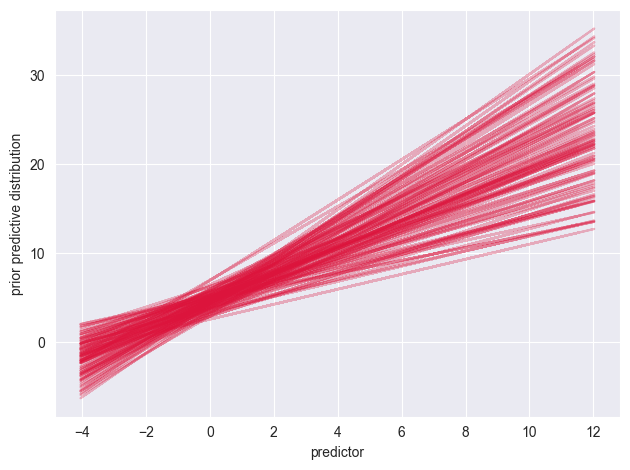

In [27]:
# Prior predictive check
y_strong_prior = (strong_prior.prior["intercept"] + strong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_strong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [28]:
# Draw posterior samples
with strong_model:
    strong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [29]:
# Print posterior distribution summaries
az.summary(strong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.8450,0.6266,3.6748,6.0209,0.0141,0.0100,1968.1325,2599.0233,1.0005
slope,2.0495,0.1096,1.8464,2.2569,0.0024,0.0017,2002.5885,2600.3010,1.0021
error,4.6354,0.3292,4.0215,5.2424,0.0063,0.0045,2757.7518,2401.6394,1.0008


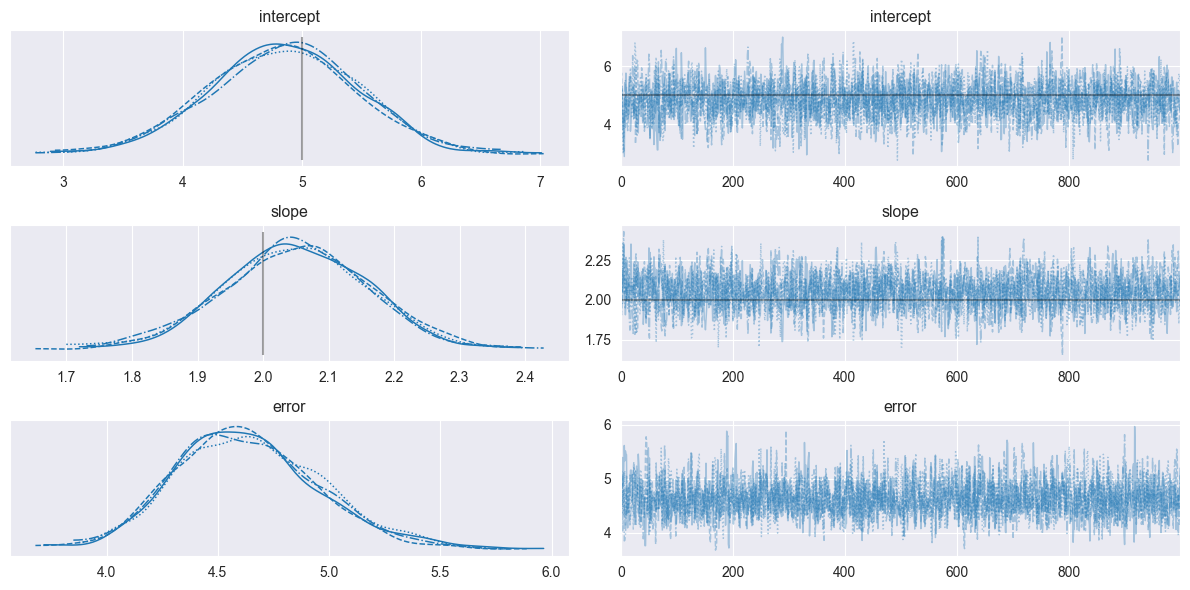

In [30]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    strong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

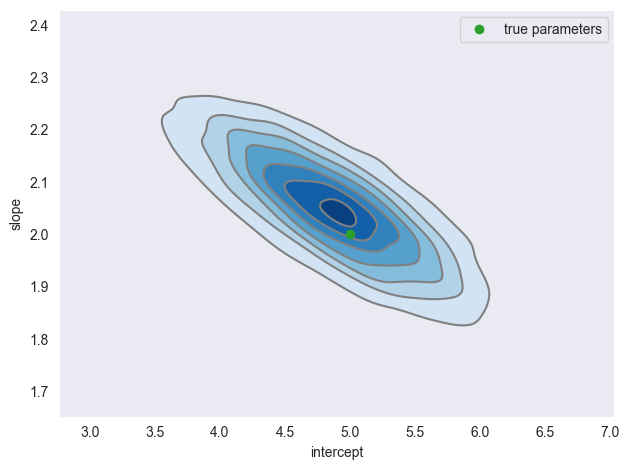

In [31]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(strong_posterior, var_names="intercept"),
    az.extract(strong_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

In [32]:
# Simulate fitted regression lines
strong_fitted = strong_posterior.posterior["intercept"] + strong_posterior.posterior["slope"] * xarray

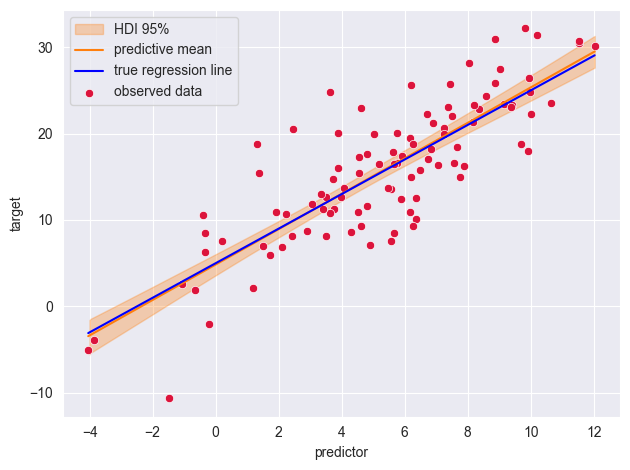

In [33]:
# Plot fitted vs. actual relationship

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    strong_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(strong_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "C1")

# True regression line
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")

# True observations
_ = sns.scatterplot(x = x, y = y, label = "observed data", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [34]:
# Sample from posterior
with strong_model:
    pm.sample_posterior_predictive(strong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


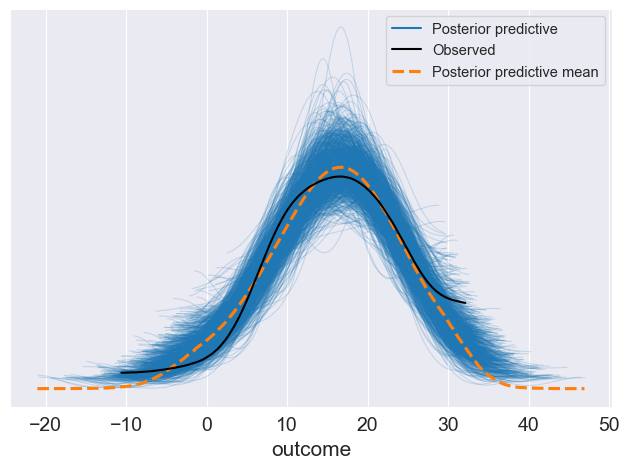

In [35]:
_ = az.plot_ppc(strong_posterior, num_pp_samples = 1000)

## Strong wrong prior

In [36]:
# Create model
wrong_model = pm.Model()

In [37]:
# Define priors & likelihood
with wrong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 1)
    slope = pm.Normal("slope", mu = 5, sigma = 0.5)
    error = pm.HalfNormal("error", sigma = 1)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [38]:
# Sample from the prior
with wrong_model:
    wrong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


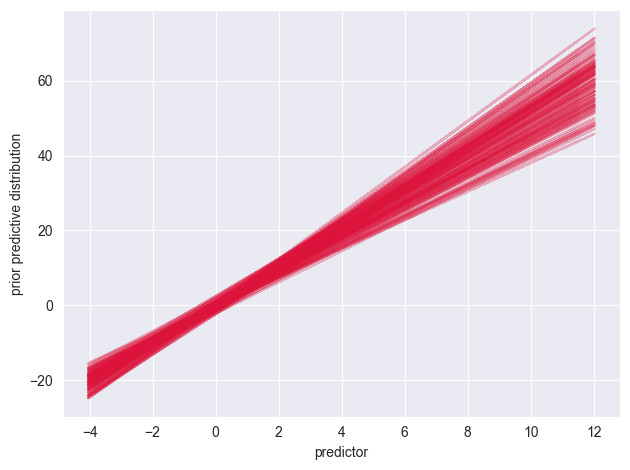

In [39]:
# Prior predictive check
y_wrong_prior = (wrong_prior.prior["intercept"] + wrong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_wrong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [40]:
# Draw posterior samples
with wrong_model:
    wrong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [41]:
# Print posterior distribution summaries
az.summary(wrong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.3169,0.6741,0.9878,3.4998,0.0154,0.0109,1924.6104,1983.4635,1.0009
slope,2.4499,0.1146,2.2463,2.6667,0.0026,0.0019,1936.7143,1848.8799,1.0015
error,4.4294,0.2812,3.9073,4.9599,0.0062,0.0044,2034.2760,2233.7323,1.0010


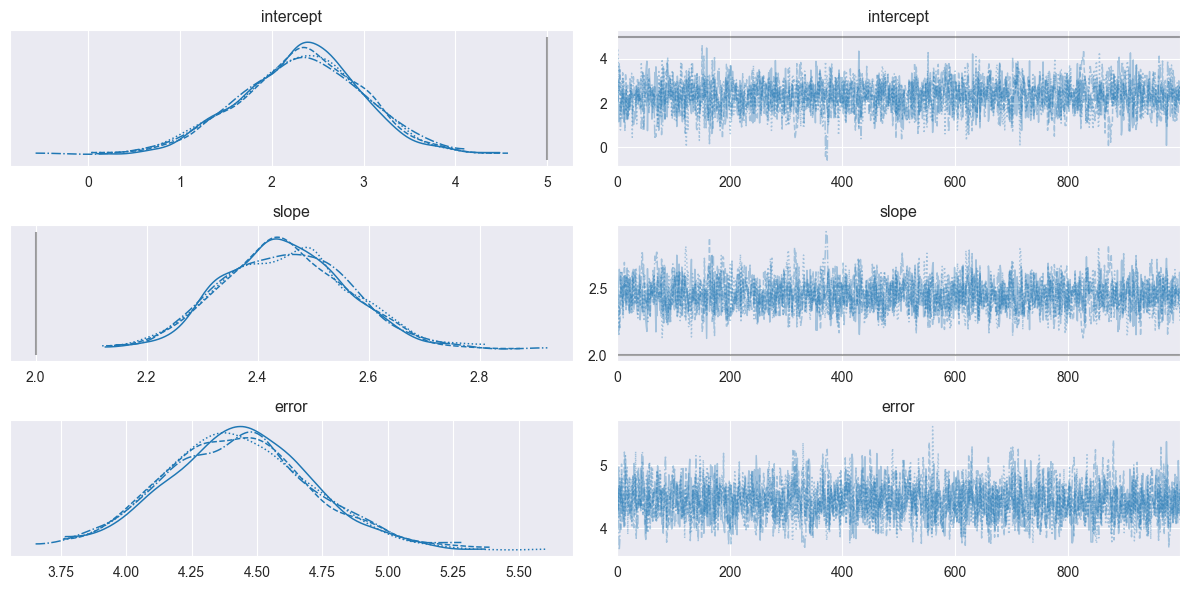

In [42]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    wrong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

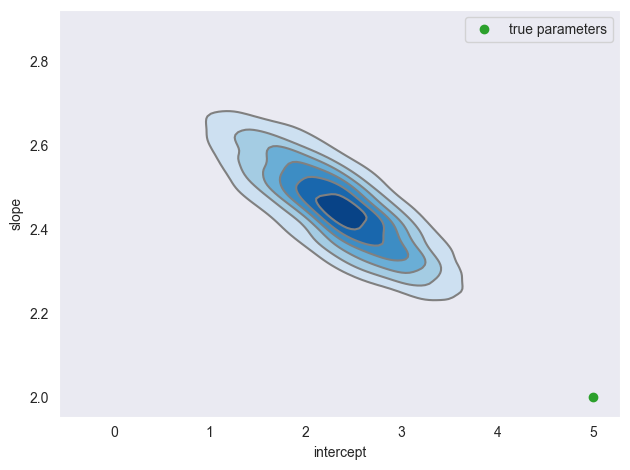

In [43]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(wrong_posterior, var_names="intercept"),
    az.extract(wrong_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

In [44]:
# Simulate fitted regression lines
wrong_fitted = wrong_posterior.posterior["intercept"] + wrong_posterior.posterior["slope"] * xarray

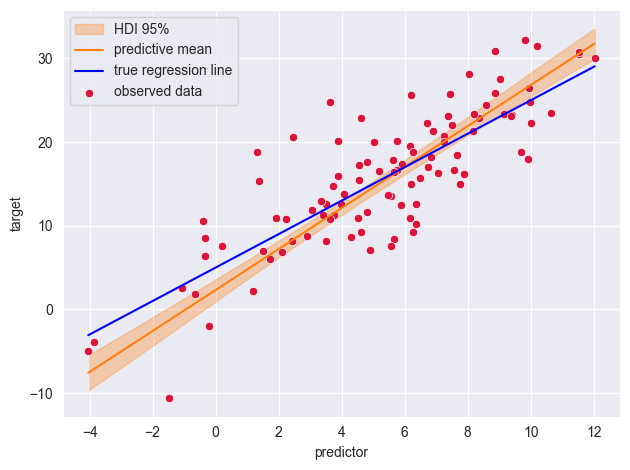

In [45]:
# Plot fitted vs. actual relationship

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    wrong_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(wrong_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "C1")

# True regression line
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")

# True observations
_ = sns.scatterplot(x = x, y = y, label = "observed data", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [46]:
# Sample from posterior
with wrong_model:
    pm.sample_posterior_predictive(wrong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


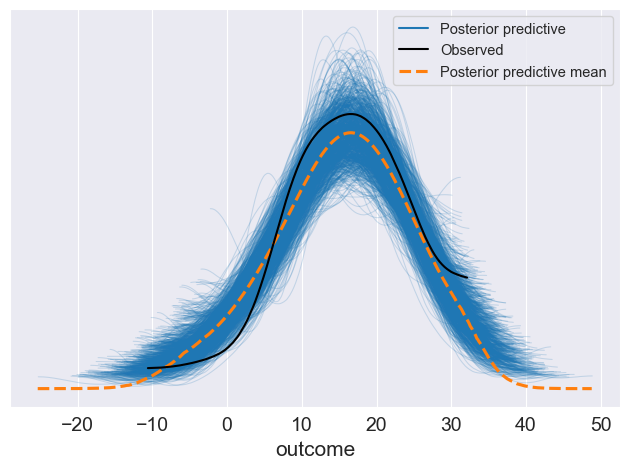

In [47]:
_ = az.plot_ppc(wrong_posterior, num_pp_samples = 1000)